In [1]:
import numpy as np
import torch
import matplotlib.pylab as pl
import pylab
import math
import proplot as plot
plot.rc['figure.facecolor'] = "white"

In [2]:
if torch.cuda.is_available():
    device='cuda'
    dtype = torch.cuda.DoubleTensor
else:
    device='cpu'
    dtype=torch.DoubleTensor
print(device)

device='cpu'
dtype=torch.DoubleTensor
torch.set_default_tensor_type(dtype)

cpu


/home/gui/.local/lib/python3.10/site-packages/torch/cuda/__init__.py:107: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


In [3]:
import sys
sys.path.append('../code/')

In [4]:
from SWGG import SWGG_CP

In [5]:
# Non continuity part

In [6]:
X=torch.tensor([[-1,1],[2,-1]]).float()
Y=torch.tensor([[1,0.75],[-2,-0.5]]).float()

num_proj=360*5
thetas = np.linspace(0, 2*np.pi, num_proj)
dire = np.array([(np.cos(theta),np.sin(theta)) for theta in thetas])
dir_torch=torch.from_numpy(dire).float().T

In [7]:
W_l,_,_=SWGG_CP(X,Y,dir_torch)

In [8]:
W_l.max(),W_l.min()

(tensor(10.1562, dtype=torch.float32), tensor(3.6562, dtype=torch.float32))

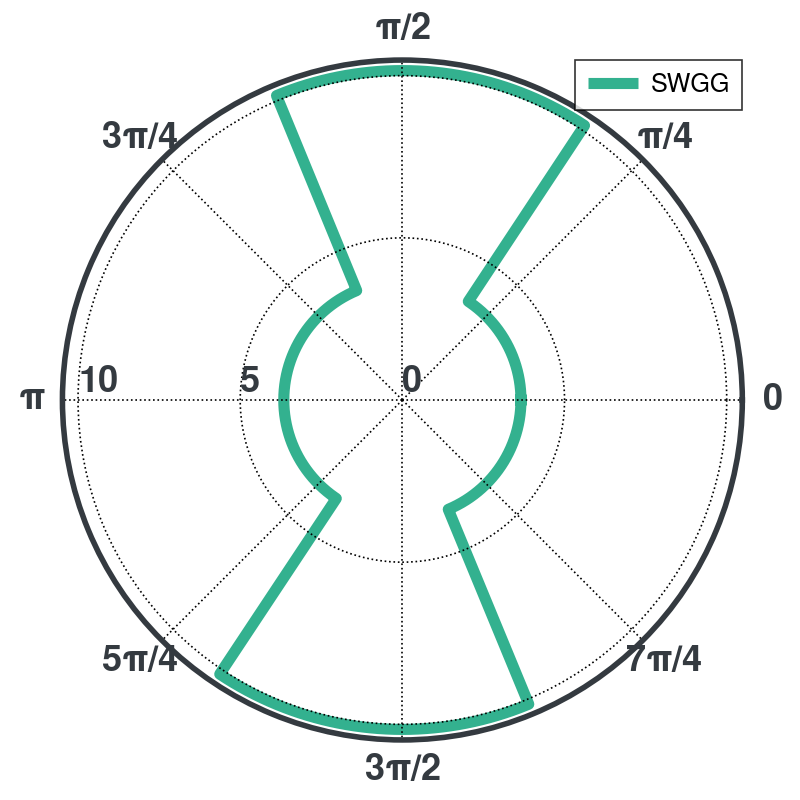

In [12]:
f, axs = plot.subplots(ncols=1, nrows=1, share=0, tight=True,proj='polar',figsize=(4,4))
axs.plot(thetas, W_l, c='C2', zorder=0, lw=4,label='SWGG',alpha=.8)
axs.format(suptitle='', linewidth=2,
           ticklabelsize=9, rlines=0.5)#, r0 = np.min(msw_theta_b)-5)
axs[0].format(thetaformatter='pi', rlines=5, gridalpha=1, gridlinestyle=':',rlabelpos=180, color='gray8', ticklabelweight='bold',ticklabelsize=13)
axs[0].legend(loc='best',width=10)
pl.savefig("non_continuity_SWGG.pdf",bbox_inches='tight')

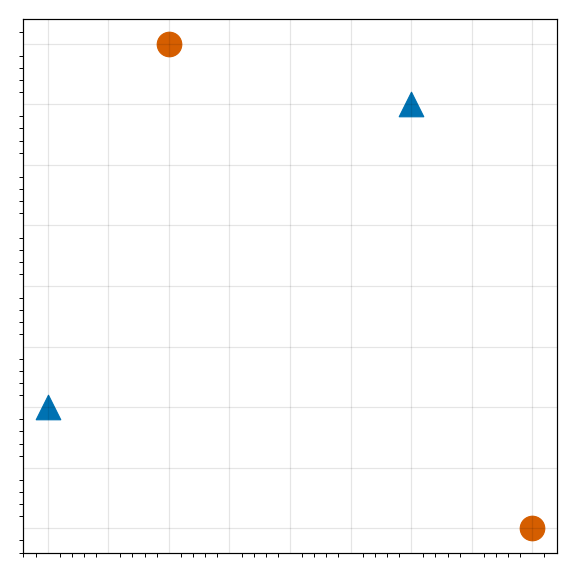

In [13]:
pl.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": "Helvetica",
})
s=150
pl.figure(figsize=(4,4))
pl.scatter(X[:, 0], X[:, 1], c='C1', label='Source',s=s)
pl.scatter(Y[:, 0], Y[:, 1], c='C0', label='Target',marker="^",s=s)
pl.tick_params(left = False, right = False , labelleft = False ,labelbottom = False, bottom = False)
pl.title('')
pl.tight_layout()
pl.savefig("non_continuity_SWGG_distrib.pdf",bbox_inches='tight')
pl.show()

In [14]:
# Continuity part

In [15]:
def SWGG_smooth(X,Y,theta,s=1,std=0):
    n,dim=X.shape
    
    X_line=torch.matmul(X,theta)
    Y_line=torch.matmul(Y,theta)
    
    X_line_sort,u=torch.sort(X_line,axis=0)
    Y_line_sort,v=torch.sort(Y_line,axis=0)
    
    X_sort=X[u]
    Y_sort=Y[v]
    
    Z_line=(X_line_sort+Y_line_sort)/2
    Z=Z_line[:,None]*theta[None,:]
    
    W_XZ=torch.sum((X_sort-Z)**2)/n
    W_YZ=torch.sum((Y_sort-Z)**2)/n
    
    X_line_extend = X_line_sort.repeat_interleave(s,dim=0)
    X_line_extend_blur = X_line_extend + 0.5 * std * torch.randn(X_line_extend.shape)
    Y_line_extend = Y_line_sort.repeat_interleave(s,dim=0)
    Y_line_extend_blur = Y_line_extend + 0.5 * std * torch.randn(Y_line_extend.shape)
    
    X_line_extend_blur_sort,u_b=torch.sort(X_line_extend_blur,axis=0)
    Y_line_extend_blur_sort,v_b=torch.sort(Y_line_extend_blur,axis=0)

    
    X_extend=X_sort.repeat_interleave(s,dim=0)
    Y_extend=Y_sort.repeat_interleave(s,dim=0)
    X_sort_extend=X_extend[u_b]
    Y_sort_extend=Y_extend[v_b]
    
    bary_extend=(X_sort_extend+Y_sort_extend)/2
    bary_blur=torch.mean(bary_extend.reshape((n,s,dim)),dim=1)
    
    W_baryZ=torch.sum((bary_blur-Z)**2)/n
    return -4*W_baryZ+2*W_XZ+2*W_YZ,bary_blur

In [16]:
import ot
import matplotlib.patches as patches


In [17]:

num_proj=360
thetas = np.linspace(0, 2*np.pi, num_proj)
dire = np.array([(np.cos(theta),np.sin(theta)) for theta in thetas])
dir_torch=torch.from_numpy(dire).to(device)

proj = dir_torch.cpu().numpy()
true_ot = ot.emd2([],[],ot.dist(X.numpy(), Y.numpy()))
swgg_theta = [SWGG_smooth(X,Y, p.float(), 1, 0)[0] for p in dir_torch]
swgg_smooth_theta = [SWGG_smooth(X,Y, p.float(), 10000, 0.8)[0] for p in dir_torch]
bary_theta = [SWGG_smooth(X,Y, p.float(), 10000, .8)[1] for p in dir_torch]
w_theta = [true_ot for p in proj]


swgg_theta_thres = np.array(np.round(swgg_theta[:-1],2))-np.array(np.round(swgg_theta[1:],2))
lines = np.where(swgg_theta_thres!=0)[0]

bary_x_true = np.zeros((2,2))
bary_x_true[0] = (X[0]+Y[0])/2
bary_x_true[1] = (X[1]+Y[1])/2
bary_y_true = np.zeros((2,2))
bary_y_true[0] = (X[0]+Y[1])/2
bary_y_true[1] = (X[1]+Y[0])/2

bary_x_gen = np.zeros((len(bary_theta),2))
bary_y_gen = np.zeros((len(bary_theta),2))
for i in range(len(bary_theta)):
    bary_x_gen[i] = bary_theta[i][0]
    bary_y_gen[i] = bary_theta[i][1]

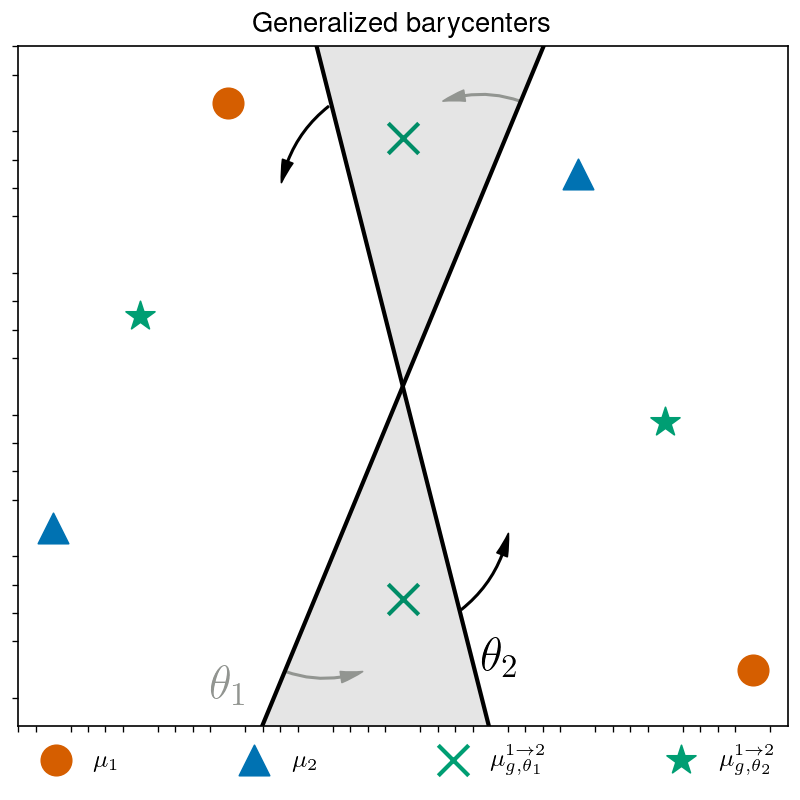

In [20]:
fig = plot.figure(share=False, figsize=(4,4))
#pl.rcParams.update({
#    "text.usetex": True,
#    "font.family": "sans-serif",
#    "font.sans-serif": "Helvetica",
#})
s=120
# Plot by passing both x and y coordinates
ax = fig.subplot(111, title='Generalized barycenters')

ax.scatter(X[:,0], X[:,1], marker = 'o', color='C1', alpha=1, label=r"$\mu_1$",s=s)
ax.scatter(Y[:,0], Y[:,1], marker='^',  color='C0', alpha=1, label=r"$\mu_2$",s=s)
ax.scatter(bary_x_true[:,0], bary_x_true[:,1], marker = 'x', color='C2', alpha=1,label=r"$\mu^{1 \to2}_{g, \theta_1}$",s=s)
ax.scatter(bary_y_true[:,0], bary_y_true[:,1], marker='*',  color='C2', alpha=1,label=r"$\mu^{1 \to2}_{g, \theta_2}$",s=s)

#draw lines corresponding to the different barycenters
ax.axline((0,0), (proj[lines[0]][0], proj[lines[0]][1]), c="k")
ax.axline((0,0), (proj[lines[1]][0], proj[lines[1]][1]), c="k")

ax.fill_between(x=[-0.5,0,0.8],y1=[1.2,0,1.2],y2=2,alpha=.1,color='k')
ax.fill_between(x=[-0.8,0,0.5],y1=[-1.2,0,-1.2],y2=-2,alpha=.1,color='k')

style = "Simple, tail_width=0.5, head_width=4, head_length=8"
kw = dict(arrowstyle=style, color="gray")
a1 = patches.FancyArrowPatch((-0.7, -1), (-0.2, -1),connectionstyle="arc3,rad=.2", **kw)
a2 = patches.FancyArrowPatch((0.7, 1), (0.2, 1),connectionstyle="arc3,rad=.2", **kw)
ax.text(-1.1, -1.1, r"$\theta_1$", fontsize=17, c="gray")

style = "Simple, tail_width=0.5, head_width=4, head_length=8"
kw = dict(arrowstyle=style, color="k")
a3 = patches.FancyArrowPatch((0.31, -0.8), (0.61, -0.5),connectionstyle="arc3,rad=.2", **kw)
a4 = patches.FancyArrowPatch((-0.4, 1), (-0.7, 0.7),connectionstyle="arc3,rad=.2", **kw)
ax.text(0.45, -1, r"$\theta_2$", fontsize=17)

for a in [a1, a2, a3, a4]:
    pl.gca().add_patch(a)

ax.grid(False)
pl.xlim(-2.2, 2.2)
pl.ylim(-1.2,1.2)
pl.legend(fontsize=27, bbox_to_anchor=(0, -0.01, 1, 0), loc="upper left", mode="expand", ncol=4, frameon=False)
pl.xlabel("")
pl.ylabel("")
ax.tick_params(left = False, right = False , labelleft = False ,labelbottom = False, bottom = False)
pl.savefig("smooth1.pdf",bbox_inches='tight')



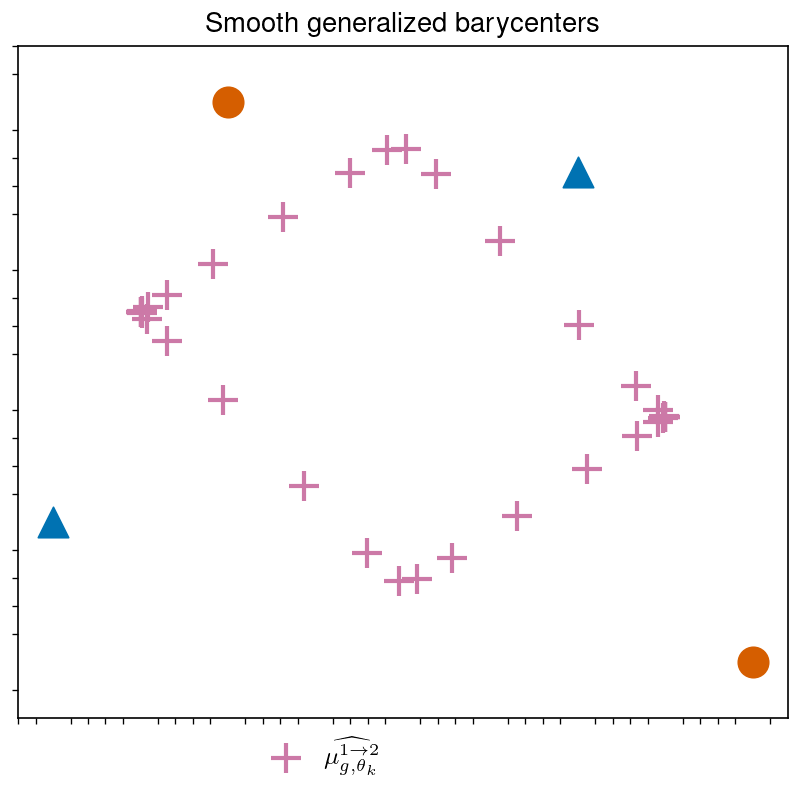

In [21]:
fig = plot.figure(share=False, figsize=(4,4))
#-----------------second plot

s=120
ax = fig.subplot(111, title='Smooth generalized barycenters')
ax.grid(False)

ax.scatter(X[:,0], X[:,1], marker = 'o', color='C1', alpha=1,s=s)
ax.scatter(Y[:,0], Y[:,1], marker='^',  color='C0', alpha=1,s=s)
ax.scatter(bary_x_gen[::10,0], bary_x_gen[::10,1], marker = '+', color='C3', alpha=1,label=r"$\widehat{\mu^{1 \to2}_{g, \theta_k}}$",s=s)


#pl.legend()
pl.grid(False)
pl.xlim(-2.2, 2.2)
pl.ylim(-1.2,1.2)
pl.tick_params(left = False, right = False , labelleft = False ,labelbottom = False, bottom = False)
pl.legend(fontsize=14, bbox_to_anchor=(0.3, -0.01, 0.45, 0), loc="upper left", mode="expand", ncol=1, frameon=False)
#fig.format(xlabel='xlabel', ylabel='ylabel')
pl.savefig("smooth2.pdf",bbox_inches='tight')

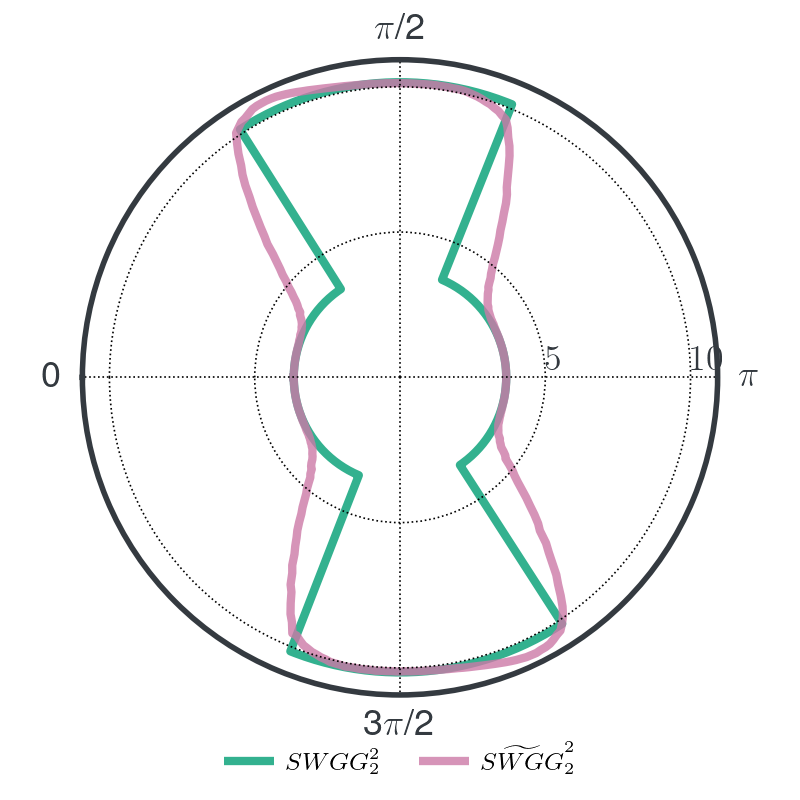

In [32]:
#-----------------third plot
f, ax = plot.subplots(ncols=1, nrows=1, share=0, tight=True,proj='polar',figsize=(4,4))
ax.plot(thetas[: num_proj], swgg_theta[: num_proj], c='C2', zorder=0, lw=3,label=r'$SWGG^2_2$',alpha=.8)
ax.plot(thetas[: num_proj], swgg_smooth_theta[: num_proj], zorder=0, lw=3,label=r'$\widetilde{SWGG}^2_2$',c='C3',alpha=.8)
ax.format(suptitle='', linewidth=2,
           ticklabelsize=9, rlines=0.5)#, r0 = np.min(msw_theta_b)-5)
ax.format(thetaformatter='pi', rlines=5, gridalpha=1, gridlinestyle=':',rlabelpos=180, color='gray8', ticklabelweight='bold',ticklabelsize=13)
pl.legend(fontsize=9, bbox_to_anchor=(-0.2, -.2, 1.4, 0.2), loc="center", ncol=2, frameon=False)
ax.format(thetadir=-1, thetalines=90, thetalim=(0, 360), theta0='W',rlines=plot.arange(5, 30, 5))
pl.savefig("smooth3.pdf",bbox_inches='tight')
